# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size =30#experiment with the batch size 

In [4]:
def crop_and_resize(image, output_l, output_w):
    # if original image l and w are same, just resize them to output_l and output_w
    # else, crop the bigger dimension to smaller dimension and resize them to output_l and output_w
    l = image.shape[0]
    w = image.shape[1]
    
    if l > w:
        image = imresize(image, (w, w))
    elif l < w:
        image = imresize(image, (l, l))
        
    return imresize(image, (output_l, output_w))

In [5]:
# Mean Normalization
def mean_normalization(image):
    return (image - image.min())/(image.max() - image.min())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def process_batch_images(source_path, folder_list, batch_size,batch,img_idx,t):    
    x=len(img_idx)
    y=120
    z=120
    
       
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes                    
            
            resized_image = crop_and_resize(image, y, z)                   
                            
            normalized_image = mean_normalization(resized_image)            
                
            batch_data[folder,idx,:,:,0] = normalized_image[:,:,0]#normalise and feed in the image
            batch_data[folder,idx,:,:,1] = normalized_image[:,:,1]#normalise and feed in the image
            batch_data[folder,idx,:,:,2] = normalized_image[:,:,2] #normalise and feed in the image
            
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels 

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0,30,2)] #create a list of image numbers you want to use for a particular video --hari
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches--hari        
        for batch in range(num_batches): # we iterate over the number of batches            
            yield process_batch_images(source_path, folder_list, batch_size,batch,img_idx,t)
        # write the code for the remaining data points which are left after full batches        
        if (len(t))%(batch_size)!=0:
            remaining_sequences = len(folder_list) % batch_size
            yield process_batch_images(source_path, folder_list, remaining_sequences,batch,img_idx,t)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
#train_path = '/notebooks/storage/Final_data/Collated_training/train'
#val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path='Project_data/train'
val_path='Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =20# choose the number of epochs(30)
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

### Conv 3d


##### Batch Size - 30 

In [10]:
model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3,3), 
                 input_shape=(15,120,120,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
#model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=(3, 3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(32, kernel_size=(3, 3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.25))          

model.add(Conv3D(32, kernel_size=(1, 3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))          

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(120, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(5, activation='softmax'))

In [11]:
optimiser =optimizers.SGD(lr=0.01) #write your optimizer #hari(0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 13, 118, 118, 64)  5248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 118, 118, 64)  256       
_________________________________________________________________
activation_1 (Activation)    (None, 13, 118, 118, 64)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 59, 59, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 57, 57, 32)     55328     
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 57, 57, 32)     128       
_________________________________________________________________
activation_2 (Activation)    (None, 4, 57, 57, 32)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
curr_dt_time = datetime.datetime.now()


In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#hari
LR =keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train ; batch size = 30
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


23/23 [==============================] - 51s 2s/step - loss: 1.8508 - categorical_accuracy: 0.3043 - val_loss: 2.6296 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2019-06-2415_35_18.920463/model-00001-1.86728-0.30317-2.62957-0.21000.h5
Epoch 2/20
23/23 [==============================] - 42s 2s/step - loss: 1.4587 - categorical_accuracy: 0.3754 - val_loss: 2.0926 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2019-06-2415_35_18.920463/model-00002-1.46813-0.37707-2.09261-0.26000.h5
Epoch 3/20
23/23 [==============================] - 43s 2s/step - loss: 1.3601 - categorical_accuracy: 0.3769 - val_loss: 3.2293 - val_categorical_accuracy: 0.1800

Epoch 00003: saving model to model_init_2019-06-2415_35_18.920463/model-00003-1.33948-0.37858-3.22935-0.18000.h5
Epoch 4/20
23/23 [==============================] - 43s 2s/step - loss: 1.2816 - categorical_accuracy: 0.4422 - val_loss: 1.5298 - val_categorical_accuracy: 0.2800

Epoch 00004:

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


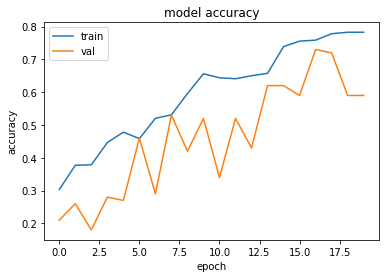

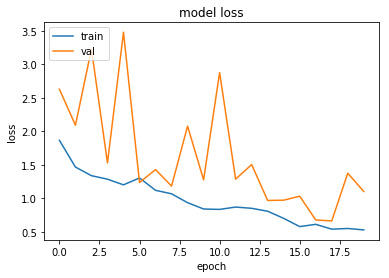

In [17]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Best model this approach 
###### Train Acc- 76.77 Val Acc=73

## Changing batch size

#### Changing batch size to 20


In [28]:
model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3,3), 
                 input_shape=(15,120,120,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
#model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=(3, 3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(32, kernel_size=(3, 3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.25))          

model.add(Conv3D(32, kernel_size=(1, 3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))          

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(120, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(5, activation='softmax'))

In [29]:
optimiser =optimizers.SGD(lr=0.01) #write your optimizer #hari(0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 13, 118, 118, 64)  5248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 118, 118, 64)  256       
_________________________________________________________________
activation_9 (Activation)    (None, 13, 118, 118, 64)  0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 6, 59, 59, 64)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 4, 57, 57, 32)     55328     
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 57, 57, 32)     128       
_________________________________________________________________
activation_10 (Activation)   (None, 4, 57, 57, 32)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [26]:
batch_size=20

In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
curr_dt_time = datetime.datetime.now()


In [31]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#hari
LR =keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 20
Source path =  Project_data/train ; batch size = 20
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


34/34 [==============================] - 47s 1s/step - loss: 1.8769 - categorical_accuracy: 0.2509 - val_loss: 2.3626 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2019-06-2415_58_30.634251/model-00001-1.86391-0.24887-2.36256-0.20000.h5
Epoch 2/20
34/34 [==============================] - 42s 1s/step - loss: 1.4619 - categorical_accuracy: 0.3804 - val_loss: 1.4069 - val_categorical_accuracy: 0.3600

Epoch 00002: saving model to model_init_2019-06-2415_58_30.634251/model-00002-1.46545-0.38160-1.40688-0.36000.h5
Epoch 3/20
34/34 [==============================] - 43s 1s/step - loss: 1.2682 - categorical_accuracy: 0.4386 - val_loss: 1.1555 - val_categorical_accuracy: 0.4400

Epoch 00003: saving model to model_init_2019-06-2415_58_30.634251/model-00003-1.28124-0.43288-1.15552-0.44000.h5
Epoch 4/20
34/34 [==============================] - 43s 1s/step - loss: 1.2216 - categorical_accuracy: 0.4864 - val_loss: 1.4048 - val_categorical_accuracy: 0.3300

Epoch 00004:

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


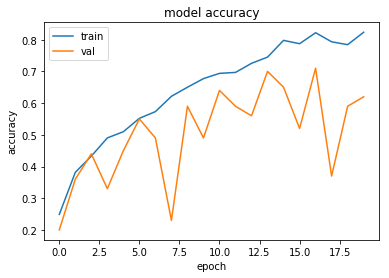

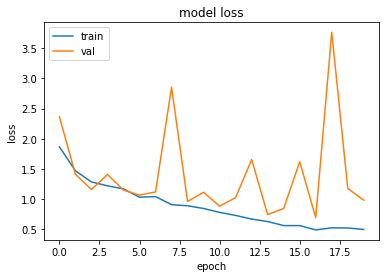

In [34]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Best model this approach 
###### Train Acc- 81.02 Val Acc=71

### Trying with more epochs   

Marked cells as Markdown as this will take around hour to complete

batch_size=30
print ('# batch_size =', batch_size)
num_epochs =50 # choose the number of epochs
print ('# epochs =', num_epochs)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#hari
LR =keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print(history.history.keys())

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
### Even for more epochs we can see that , Still there is not much difference 

#### Same model with different parameters for ReduceLROnPlateau

In [43]:
model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3,3), 
                 input_shape=(15,120,120,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
#model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=(3, 3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(32, kernel_size=(3, 3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.25))          

model.add(Conv3D(32, kernel_size=(1, 3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))          

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(120, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(5, activation='softmax'))

In [44]:
optimiser =optimizers.SGD(lr=0.01) #write your optimizer #hari(0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 13, 118, 118, 64)  5248      
_________________________________________________________________
batch_normalization_17 (Batc (None, 13, 118, 118, 64)  256       
_________________________________________________________________
activation_17 (Activation)   (None, 13, 118, 118, 64)  0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 6, 59, 59, 64)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 4, 57, 57, 32)     55328     
_________________________________________________________________
batch_normalization_18 (Batc (None, 4, 57, 57, 32)     128       
_________________________________________________________________
activation_18 (Activation)   (None, 4, 57, 57, 32)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [45]:
batch_size=30
num_epochs =20 


In [46]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [47]:
curr_dt_time = datetime.datetime.now()


In [48]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#hari
LR =keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='auto', cooldown=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [49]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [50]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/valSource path =  Project_data/train ; batch size = ; batch size = 30
 30
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


23/23 [==============================] - 49s 2s/step - loss: 1.8026 - categorical_accuracy: 0.2732 - val_loss: 2.1686 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2019-06-2416_13_58.226141/model-00001-1.83129-0.25792-2.16865-0.24000.h5
Epoch 2/20
23/23 [==============================] - 43s 2s/step - loss: 1.3610 - categorical_accuracy: 0.4239 - val_loss: 2.2052 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to model_init_2019-06-2416_13_58.226141/model-00003-1.31277-0.44042-2.20518-0.22000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 4/20
23/23 [==============================] - 44s 2s/step - loss: 1.3340 - categorical_accuracy: 0.4402 - val_loss: 1.0156 - val_categorical_accuracy: 0.5500

Epoch 00004: saving model to model_init_2019-06-2416_13_58.226141/model-00004-1.33862-0.43137-1.01556-0.55000.h5
Epoch 5/20
23/23 [==============================] - 43s 2s/step - loss: 1.1861 - categorical_accu

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


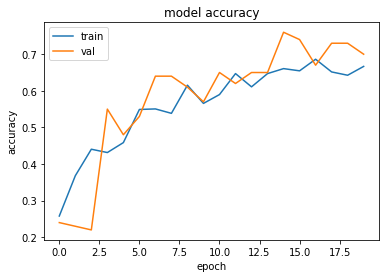

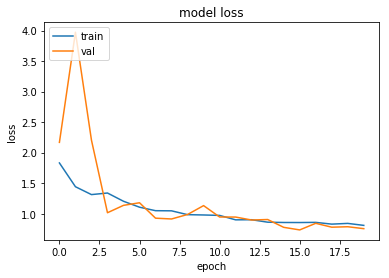

In [51]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Best model this approach 
###### Train Acc- 67.34 Val Acc=76

#### Trying the model With Adam optmizer

In [52]:
model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3,3), 
                 input_shape=(15,120,120,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
#model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=(3, 3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(32, kernel_size=(3, 3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.25))          

model.add(Conv3D(32, kernel_size=(1, 3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))          

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(120, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(5, activation='softmax'))

In [53]:
optimiser =optimizers.Adam() #write your optimizer #hari(0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 13, 118, 118, 64)  5248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 13, 118, 118, 64)  256       
_________________________________________________________________
activation_21 (Activation)   (None, 13, 118, 118, 64)  0         
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 6, 59, 59, 64)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 4, 57, 57, 32)     55328     
_________________________________________________________________
batch_normalization_22 (Batc (None, 4, 57, 57, 32)     128       
_________________________________________________________________
activation_22 (Activation)   (None, 4, 57, 57, 32)     0         
__________

In [54]:
batch_size=30
print ('# batch_size =', batch_size)
num_epochs =20 # choose the number of epochs(30)
print ('# epochs =', num_epochs)

# batch_size = 30
# epochs = 20


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [55]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [56]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#hari
LR =keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='auto', cooldown=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [57]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [58]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train ; batch size = 30
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


23/23 [==============================] - 49s 2s/step - loss: 2.0658 - categorical_accuracy: 0.2979 - val_loss: 2.2346 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2019-06-2416_28_51.361605/model-00001-2.10246-0.28356-2.23459-0.18000.h5
Epoch 2/20
23/23 [==============================] - 41s 2s/step - loss: 1.3895 - categorical_accuracy: 0.3313 - val_loss: 1.2769 - val_categorical_accuracy: 0.3800

Epoch 00002: saving model to model_init_2019-06-2416_28_51.361605/model-00002-1.40126-0.31825-1.27686-0.38000.h5
Epoch 3/20
23/23 [==============================] - 44s 2s/step - loss: 1.3397 - categorical_accuracy: 0.3424 - val_loss: 1.2111 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model_init_2019-06-2416_28_51.361605/model-00003-1.33332-0.31674-1.21115-0.45000.h5
Epoch 4/20
23/23 [==============================] - 44s 2s/step - loss: 1.2809 - categorical_accuracy: 0.4117 - val_loss: 1.1861 - val_categorical_accuracy: 0.4900

Epoch 00004:

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


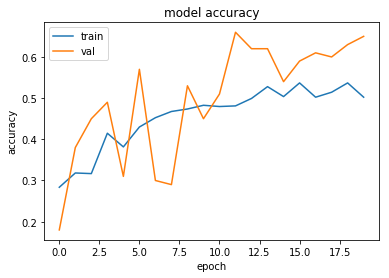

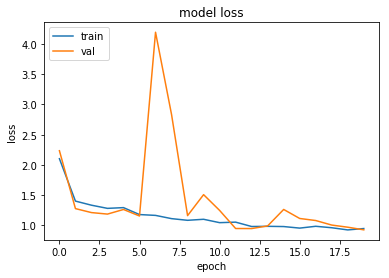

In [59]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Best model this approach 
###### Train Acc- 47.56 Val Acc=66

### CNN- RNN Model

### using GRU model

In [60]:
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers import LSTM, GRU
model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3,3), padding='same'),input_shape=(15, 120, 120, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.50)))

model.add(TimeDistributed(Conv2D(16, (3,3))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.50)))

model.add(TimeDistributed(Flatten()))
model.add(GRU(120, return_sequences= True))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [61]:
optimiser =optimizers.SGD(lr=0.01) #write your optimizer #hari(0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 120, 120, 8)   224       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 120, 120, 8)   32        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 60, 60, 8)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 60, 60, 8)     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 58, 58, 16)    1168      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 58, 58, 16)    64        
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 29, 29, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [62]:
batch_size=30
print ('# batch_size =', batch_size)
num_epochs =20 # choose the number of epochs(30)
print ('# epochs =', num_epochs)

# batch_size = 30
# epochs = 20


In [63]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [64]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#hari
LR =keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [65]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [66]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train ; batch size = 30
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


23/23 [==============================] - 47s 2s/step - loss: 2.2851 - categorical_accuracy: 0.2230 - val_loss: 1.6975 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2019-06-2416_28_51.361605/model-00001-2.31188-0.21870-1.69746-0.37000.h5
Epoch 2/20
23/23 [==============================] - 39s 2s/step - loss: 1.6142 - categorical_accuracy: 0.3542 - val_loss: 1.3219 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2019-06-2416_28_51.361605/model-00002-1.57582-0.36802-1.32191-0.47000.h5
Epoch 3/20
23/23 [==============================] - 42s 2s/step - loss: 1.4269 - categorical_accuracy: 0.4504 - val_loss: 1.5253 - val_categorical_accuracy: 0.3900

Epoch 00003: saving model to model_init_2019-06-2416_28_51.361605/model-00003-1.43429-0.44193-1.52525-0.39000.h5
Epoch 4/20
23/23 [==============================] - 41s 2s/step - loss: 1.1309 - categorical_accuracy: 0.5409 - val_loss: 2.3554 - val_categorical_accuracy: 0.2900

Epoch 00004:

In [67]:
history.history.keys()

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


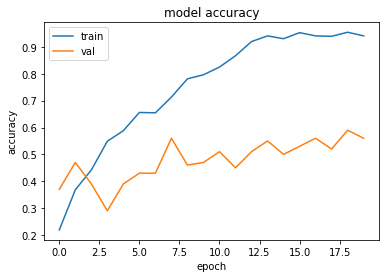

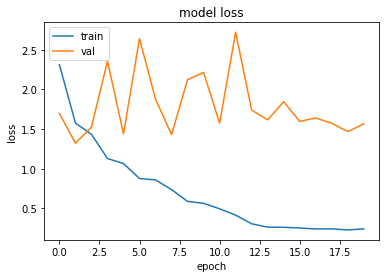

In [68]:


### list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Best model this approach 
###### Train Acc- 95.64 Val Acc=59

### Using LSTM

In [70]:

model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3,3), padding='same'),input_shape=(15, 120, 120, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.50)))

model.add(TimeDistributed(Conv2D(16, (3,3))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.50)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(120, return_sequences= True))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [71]:
optimiser =optimizers.SGD(lr=0.01) #write your optimizer #hari(0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 15, 120, 120, 8)   224       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 120, 120, 8)   32        
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 60, 60, 8)     0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 60, 60, 8)     0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 58, 58, 16)    1168      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 58, 58, 16)    64        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 29, 29, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [72]:
batch_size=30
print ('# batch_size =', batch_size)
num_epochs =20 # choose the number of epochs(30)
print ('# epochs =', num_epochs)

# batch_size = 30
# epochs = 20


In [73]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [74]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#hari
LR =keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [75]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [76]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train ; batch size = 30
 Project_data/val Epoch 1/20
; batch size = 30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


23/23 [==============================] - 47s 2s/step - loss: 1.6086 - categorical_accuracy: 0.2593 - val_loss: 1.4533 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2019-06-2416_28_51.361605/model-00001-1.62257-0.25641-1.45335-0.39000.h5
Epoch 2/20
23/23 [==============================] - 41s 2s/step - loss: 1.2164 - categorical_accuracy: 0.5282 - val_loss: 1.5423 - val_categorical_accuracy: 0.4400

Epoch 00004: saving model to model_init_2019-06-2416_28_51.361605/model-00004-1.23634-0.50980-1.54226-0.44000.h5
Epoch 5/20
23/23 [==============================] - 42s 2s/step - loss: 1.1144 - categorical_accuracy: 0.5520 - val_loss: 1.6976 - val_categorical_accuracy: 0.3800

Epoch 00005: saving model to model_init_2019-06-2416_28_51.361605/model-00005-1.11911-0.54751-1.69761-0.38000.h5
Epoch 6/20
23/23 [==============================] - 42s 2s/step - loss: 1.0523 - categorical_accuracy: 0.5781 - val_loss: 1.7832 - val_categorical_accuracy: 0.3100

Epoch 00006:

In [77]:
history.history.keys()

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


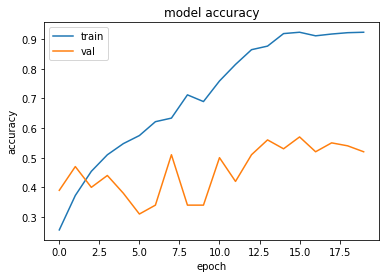

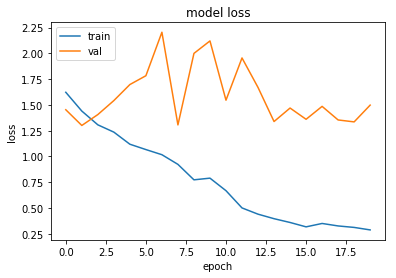

In [78]:


### list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Best model this approach 
###### Train Acc- 91.35 Val Acc=57